In [1]:
from transformers import BartTokenizer, BartModel
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
import gym
import numpy as np
from datasets import load_dataset
import random
import torch
import matplotlib.pyplot as plt

2024-02-02 00:03:42.359081: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-02 00:03:42.378193: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 00:03:42.378213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 00:03:42.378691: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 00:03:42.381973: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import string
from random import randint
from pattern.en import pluralize, singularize
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

def drop_stop_words(sentence):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(sentence)
    filtered_sentence = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_sentence)

def remove_punctuation(sentence):
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    return sentence

def to_lowercase(sentence):
    return sentence.lower()

def negate_sentence(sentence):
    negation_words = ['not', 'no', 'never', 'none', 'nothing', 'nobody', 'neither', 'nowhere', 'hardly', 'scarcely', 'barely', 'don’t', 'isn’t', 'wasn’t', 'shouldn’t', 'wouldn’t', 'couldn’t', 'won’t', 'can’t', 'doesn’t']
    word_tokens = word_tokenize(sentence)
    negated_sentence = []
    negated = False

    for word in word_tokens:
        if word in negation_words:
            negated = not negated
            continue
        negated_sentence.append("not " + word if negated else word)

    return ' '.join(negated_sentence)

def return_random_number(begin, end):
    return randint(begin, end)

def delete_random_character(sentence):
    """
    This function takes a sentence, randomly selects a word, then randomly deletes a character from it.
    """
    sample_tokenized = nltk.word_tokenize(sentence)

    # Select a random word
    random_word_index = 0
    random_word_selected = False

    while not random_word_selected:
        random_word_index = return_random_number(0, len(sample_tokenized)-1)
        if len(sample_tokenized[random_word_index]) > 2:
            random_word_selected = True

    selected_word = sample_tokenized[random_word_index]

    # Delete a random character
    random_char_index = return_random_number(1, len(selected_word)-2)
    perturbed_word = selected_word[:random_char_index] + selected_word[random_char_index+1:]

    # Reconstruct the perturbed sample
    perturbed_sample = " ".join(sample_tokenized[:random_word_index] + [perturbed_word] + sample_tokenized[random_word_index+1:])

    return perturbed_sample

def insert_random_character(sentence):
    """
    This function takes a sentence, randomly selects a word, then randomly inserts a character into it.
    """
    sample_tokenized = nltk.word_tokenize(sentence)

    # Select a random word
    random_word_index = 0
    random_word_selected = False

    while not random_word_selected:
        random_word_index = return_random_number(0, len(sample_tokenized)-1)
        if len(sample_tokenized[random_word_index]) > 2:
            random_word_selected = True

    selected_word = sample_tokenized[random_word_index]

    # Insert a random character
    random_char_index = return_random_number(1, len(selected_word)-1)
    random_char_code = return_random_number(97, 122)
    random_char = chr(random_char_code)

    perturbed_word = selected_word[:random_char_index] + random_char + selected_word[random_char_index:]

    # Reconstruct the perturbed sample
    perturbed_sample = " ".join(sample_tokenized[:random_word_index] + [perturbed_word] + sample_tokenized[random_word_index+1:])

    return perturbed_sample

def random_changing_type():
    return 'FirstChar' if randint(1, 2) == 1 else 'AllChars'

def change_letter_case(sentence):
    """
    This function takes a sentence, randomly selects a word, then changes the case of the first character
    or all characters in that word.
    """
    sample_tokenized = nltk.word_tokenize(sentence)

    # Select a random word
    random_word_index = 0
    random_word_selected = False

    while not random_word_selected:
        random_word_index = return_random_number(0, len(sample_tokenized)-1)
        if len(sample_tokenized[random_word_index]) > 2:
            random_word_selected = True

    selected_word = sample_tokenized[random_word_index]

    # Change the letter case
    change_type = random_changing_type()
    temp_word = ""

    if change_type == 'FirstChar':
        # Toggle case of the first character
        char = selected_word[0]
        temp_word = char.lower() if char.isupper() else char.upper()
        temp_word += selected_word[1:]
    elif change_type == 'AllChars':
        # Toggle case of all characters
        for char in selected_word:
            temp_word += char.lower() if char.isupper() else char.upper()

    # Reconstruct the perturbed sample
    perturbed_sample = " ".join(sample_tokenized[:random_word_index] + [temp_word] + sample_tokenized[random_word_index+1:])

    return perturbed_sample

def generate_misspelling(word):
    """
    This function takes a word and generates a misspelling by randomly altering a character.
    """
    if len(word) > 1:
        random_char_index = return_random_number(0, len(word) - 1)
        random_char_code = return_random_number(97, 122)
        random_char = chr(random_char_code)

        misspelled_word = word[:random_char_index] + random_char + word[random_char_index+1:]
        return misspelled_word
    else:
        return word

def apply_misspellings(sentence, max_perturb=10):
    """
    This function takes a sentence and applies misspelling perturbations by randomly altering characters in words.
    """
    sample_tokenized = nltk.word_tokenize(sentence)
    perturbed_sample = sentence
    word_replaced = False

    num_replacements = 0
    while num_replacements < min(max_perturb, len(sample_tokenized)):
        random_word_index = return_random_number(0, len(sample_tokenized) - 1)
        selected_word = sample_tokenized[random_word_index]

        misspelled_word = generate_misspelling(selected_word)

        if misspelled_word != selected_word:
            perturbed_sample = perturbed_sample.replace(selected_word, misspelled_word, 1)
            num_replacements += 1
            word_replaced = True

    return perturbed_sample if word_replaced else sentence

def repeat_random_character(sentence):
    """
    This function takes a sentence, randomly selects a word, then randomly repeats a character in that word.
    """
    sample_tokenized = nltk.word_tokenize(sentence)

    # Select a random word
    random_word_index = 0
    random_word_selected = False

    while not random_word_selected:
        random_word_index = return_random_number(0, len(sample_tokenized)-1)
        if len(sample_tokenized[random_word_index]) > 2:
            random_word_selected = True

    selected_word = sample_tokenized[random_word_index]

    # Repeat a random character
    random_char_index = return_random_number(1, len(selected_word)-2)
    repeated_char = selected_word[random_char_index]

    perturbed_word = selected_word[:random_char_index] + repeated_char + selected_word[random_char_index:]

    # Reconstruct the perturbed sample
    perturbed_sample = " ".join(sample_tokenized[:random_word_index] + [perturbed_word] + sample_tokenized[random_word_index+1:])

    return perturbed_sample

def return_adjacent_char(input_char):

    if (input_char == 'a'):
        return 's'

    elif (input_char == 'b'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'v'
        else:
            return 'n'

    elif (input_char == 'c'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'x'
        else:
            return 'v'

    elif (input_char == 'd'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 's'
        else:
            return 'f'

    elif (input_char == 'e'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'w'
        else:
            return 'r'

    elif (input_char == 'f'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'd'
        else:
            return 'g'

    elif (input_char == 'g'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'f'
        else:
            return 'h'

    elif (input_char == 'h'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'g'
        else:
            return 'j'

    elif (input_char == 'i'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'u'
        else:
            return 'o'

    elif (input_char == 'j'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'h'
        else:
            return 'k'

    elif (input_char == 'k'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'j'
        else:
            return 'l'

    elif (input_char == 'l'):
        return 'k'

    elif (input_char == 'm'):
        return 'n'

    elif (input_char == 'n'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'b'
        else:
            return 'm'

    elif (input_char == 'o'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'i'
        else:
            return 'p'

    elif (input_char == 'p'):
        return 'o'

    elif (input_char == 'q'):
        return 'w'

    elif (input_char == 'r'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'e'
        else:
            return 't'

    elif (input_char == 's'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'a'
        else:
            return 'd'

    elif (input_char == 't'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'r'
        else:
            return 'y'

    elif (input_char == 'u'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'y'
        else:
            return 'i'

    elif (input_char == 'v'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'c'
        else:
            return 'b'

    elif (input_char == 'w'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'q'
        else:
            return 'e'

    elif (input_char == 'x'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'z'
        else:
            return 'c'

    elif (input_char == 'y'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 't'
        else:
            return 'u'

    elif (input_char == 'z'):
        return 'x'
    #---------------------------------------------
    elif (input_char == 'A'):
        return 'S'

    elif (input_char == 'B'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'V'
        else:
            return 'N'

    elif (input_char == 'C'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'X'
        else:
            return 'V'

    elif (input_char == 'D'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'S'
        else:
            return 'F'

    elif (input_char == 'E'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'W'
        else:
            return 'R'

    elif (input_char == 'F'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'D'
        else:
            return 'G'

    elif (input_char == 'G'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'F'
        else:
            return 'H'

    elif (input_char == 'H'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'G'
        else:
            return 'J'

    elif (input_char == 'I'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'U'
        else:
            return 'O'

    elif (input_char == 'J'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'H'
        else:
            return 'K'

    elif (input_char == 'K'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'J'
        else:
            return 'L'

    elif (input_char == 'L'):
        return 'K'

    elif (input_char == 'M'):
        return 'N'

    elif (input_char == 'N'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'B'
        else:
            return 'M'

    elif (input_char == 'O'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'I'
        else:
            return 'P'

    elif (input_char == 'P'):
        return 'O'

    elif (input_char == 'Q'):
        return 'W'

    elif (input_char == 'R'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'E'
        else:
            return 'T'

    elif (input_char == 'S'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'A'
        else:
            return 'D'

    elif (input_char == 'T'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'R'
        else:
            return 'Y'

    elif (input_char == 'U'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'Y'
        else:
            return 'I'

    elif (input_char == 'V'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'C'
        else:
            return 'B'

    elif (input_char == 'W'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'Q'
        else:
            return 'E'

    elif (input_char == 'X'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'Z'
        else:
            return 'C'

    elif (input_char == 'Y'):
        which_adjacent = return_random_number(1, 2)
        if (which_adjacent == 1):
            return 'T'
        else:
            return 'U'

    elif (input_char == 'Z'):
        return 'X'

    else:
        return '*'

def replace_with_adjacent_character(sentence):
    """
    This function takes a sentence, randomly selects a word, then randomly replaces a character in that word.
    """
    sample_tokenized = nltk.word_tokenize(sentence)

    # Select a random word
    random_word_index = 0
    random_word_selected = False

    while not random_word_selected:
        random_word_index = return_random_number(0, len(sample_tokenized)-1)
        if len(sample_tokenized[random_word_index]) > 2:
            random_word_selected = True

    selected_word = sample_tokenized[random_word_index]

    # Replace a random character
    random_char_index = return_random_number(1, len(selected_word)-2)
    char_to_replace = selected_word[random_char_index]
    adjacent_char = return_adjacent_char(char_to_replace)

    perturbed_word = selected_word[:random_char_index] + adjacent_char + selected_word[random_char_index+1:]

    # Reconstruct the perturbed sample
    perturbed_sample = " ".join(sample_tokenized[:random_word_index] + [perturbed_word] + sample_tokenized[random_word_index+1:])

    return perturbed_sample

def swap_characters(input_word, position, adjacent):
    temp_word = ''
    if (adjacent == 'left'):
        if (position == 1):
            temp_word = input_word[1]
            temp_word += input_word[0]
            temp_word += input_word[2:]
        elif (position == len(input_word)-1):
            temp_word = input_word[0:position-1]
            temp_word += input_word[position]
            temp_word += input_word[position-1]
        elif (position > 1 and position < len(input_word)-1):
            temp_word = input_word[0:position-1]
            temp_word += input_word[position]
            temp_word += input_word[position-1]
            temp_word += input_word[position+1:]

    elif (adjacent == 'right'):
        if (position == 0):
            temp_word = input_word[1]
            temp_word += input_word[0]
            temp_word += input_word[2:]
        elif (position == len(input_word)-2):
            temp_word = input_word[0:position]
            temp_word += input_word[position+1]
            temp_word += input_word[position]
        elif (position > 0 and position < len(input_word)-2):
            temp_word = input_word[0:position]
            temp_word += input_word[position+1]
            temp_word += input_word[position]
            temp_word += input_word[position+2:]

    return temp_word

def swap_random_character(sentence):
    """
    This function takes a sentence, randomly selects a word, then randomly swaps a character in that word with its adjacent character.
    """
    sample_tokenized = nltk.word_tokenize(sentence)

    # Select a random word
    random_word_index = 0
    random_word_selected = False

    while not random_word_selected:
        random_word_index = return_random_number(0, len(sample_tokenized)-1)
        if len(sample_tokenized[random_word_index]) > 2:
            random_word_selected = True

    selected_word = sample_tokenized[random_word_index]

    # Select a random character and its adjacent for swapping
    random_char_index = return_random_number(0, len(selected_word)-1)
    adjacent_for_swapping = 'right' if random_char_index == 0 else 'left' if random_char_index == len(selected_word)-1 else 'left' if return_random_number(1, 2) == 1 else 'right'

    # Swap the character and the adjacent
    perturbed_word = swap_characters(selected_word, random_char_index, adjacent_for_swapping)

    # Reconstruct the perturbed sample
    perturbed_sample = " ".join(sample_tokenized[:random_word_index] + [perturbed_word] + sample_tokenized[random_word_index+1:])

    return perturbed_sample

def delete_random_word(sentence):
    """
    This function takes a sentence, tokenizes it, and randomly deletes one of the words.
    """
    sample_tokenized = nltk.word_tokenize(sentence)

    # Select a random word to delete
    random_word_index = return_random_number(0, len(sample_tokenized)-1)

    # Ensure the selected word has more than one character (optional, can be adjusted)
    while len(sample_tokenized[random_word_index]) <= 1:
        random_word_index = return_random_number(0, len(sample_tokenized)-1)

    # Delete the word and reconstruct the sentence
    del sample_tokenized[random_word_index]
    perturbed_sample = " ".join(sample_tokenized)

    return perturbed_sample


def change_ordering(input_length, input_side, input_changes):
    ordering = []

    if (input_side == 1):
        for i in range(0, input_length):
            if (i < input_changes):

                candidates=[]
                for j in range(0, input_changes):
                    if (j != i and j not in ordering):
                        candidates.append(j)

                if (len(candidates) > 0):
                    random_index = return_random_number(0, len(candidates)-1)
                    ordering.append(candidates[random_index])
                else:
                    ordering.append(i)
            else:
                ordering.append(i)

    elif (input_side == 2):
        for i in range(0, input_length):
            if (i < input_length-input_changes):
                ordering.append(i)

            else:
                candidates=[]
                for j in range(input_length-input_changes, input_length):
                    if (j != i and j not in ordering):
                        candidates.append(j)

                if (len(candidates) > 0):
                    random_index = return_random_number(0, len(candidates)-1)
                    ordering.append(candidates[random_index])
                else:
                    ordering.append(i)

    return ordering

def perturb_word_order(sentence):
    """
    This function takes a sentence, tokenizes it, and randomly changes the order of the words.
    """
    sample_tokenized = nltk.word_tokenize(sentence)

    perturbed_sample = ""
    if len(sample_tokenized) > 3:
        last_token = ""
        if sample_tokenized[-1] in ('.', '?', '!', ';', ','):
            last_token = sample_tokenized[-1]
            sample_tokenized = sample_tokenized[:-1]

        ordering_side = return_random_number(1, 2)
        num_changed_words = return_random_number(2, len(sample_tokenized)-1)
        new_word_order = change_ordering(len(sample_tokenized), ordering_side, num_changed_words)

        for i in new_word_order:
            perturbed_sample += sample_tokenized[i] + ' '
        perturbed_sample += last_token
    else:
        perturbed_sample = sentence

    return perturbed_sample

def repeat_random_word(sentence):
    """
    This function takes a sentence, tokenizes it, and randomly repeats one of the words.
    """
    sample_tokenized = nltk.word_tokenize(sentence)

    # Select a random word to repeat
    random_word_index = return_random_number(0, len(sample_tokenized)-1)

    # Ensure the selected word has more than one character (optional, can be adjusted)
    while len(sample_tokenized[random_word_index]) <= 1:
        random_word_index = return_random_number(0, len(sample_tokenized)-1)

    selected_word = sample_tokenized[random_word_index]

    # Reconstruct the sentence with the repeated word
    perturbed_sample = " ".join(sample_tokenized[:random_word_index+1] + [selected_word] + sample_tokenized[random_word_index+1:])

    return perturbed_sample

def toggle_singular_plural(sentence):
    """
    This function takes a sentence, tokenizes it, and randomly changes one of the words from singular to plural or vice versa.
    """
    sample_tokenized = nltk.word_tokenize(sentence)

    # Select a random word
    random_word_index = return_random_number(0, len(sample_tokenized)-1)

    selected_word = sample_tokenized[random_word_index]
    word_synsets = wordnet.synsets(selected_word)

    # Check if the word is likely a noun (this is a simplification and might not always be accurate)
    if word_synsets and word_synsets[0].pos() in ['n', 's']:
        if pluralize(singularize(selected_word)) == selected_word:  # If the word is singular
            new_word = pluralize(selected_word)
        else:  # If the word is plural
            new_word = singularize(selected_word)

        sample_tokenized[random_word_index] = new_word

    # Reconstruct the sentence
    perturbed_sample = " ".join(sample_tokenized)

    return perturbed_sample

def is_third_person(input_pos_tag):
    subject = ''
    for i in range(0, len(input_pos_tag)):
        token = input_pos_tag[i]
        if (subject == ''):
            if (token[0].lower() in ('it', 'this', 'that', 'he', 'she')):
                subject = 'third person'
            elif (token[1] in ('NNP')):
                subject = 'third person'
            elif (token[0].lower() in ('i', 'we', 'you', 'they', 'she', 'these', 'those')):
                subject = 'not third person'
            elif (token[0].lower() in ('NNPS')):
                subject = 'not third person'
    if (subject == 'third person'):
        return 'third person'
    elif (subject == 'not third person'):
        return 'not third person'
    else:
        return 'none'

def change_verb_tense(sentence):
    """
    This function takes a sentence and changes the tense of verbs found in the sentence.
    """
    sample_tokenized = nltk.word_tokenize(sentence)
    sample_pos_tag = nltk.pos_tag(sample_tokenized)

    # ... [Include the rest of the verb tense changing logic from your original script here] ...

    # Reconstruct the perturbed sample
    perturbed_sample = " ".join([token for token, _ in sample_pos_tag])

    return perturbed_sample


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/local/ASURITE/bpathir1/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/local/ASURITE/bpathir1/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/local/ASURITE/bpathir1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/local/ASURITE/bpathir1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("Falconsai/text_summarization")
model = AutoModelForSeq2SeqLM.from_pretrained("Falconsai/text_summarization")

dataset = load_dataset("openai/summarize_from_feedback", 'axis')

In [5]:
def get_summary(text, max_length=130, min_length=40):
    # Encode the input text and add the special tokens for the model
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", truncation=True)

    # Generate summary with the model
    summary_ids = model.generate(inputs, max_length=max_length, min_length=min_length, length_penalty=2.0, num_beams=4, early_stopping=True)

    # Decode and return the summary
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Example usage
original_text = sentence*7
summary = get_summary(original_text)
print(summary)

The renowned scientist, after years of groundbreaking research, presented her findings at the international conference, emphasizing the urgent need for immediate action to combat climate change. Furthermore, she highlighted the critical role of innovative technologies in sustainable development and called for increased international collaboration to foster a global response to environmental issues.


In [6]:
import sacrebleu

def calculate_bleu_score(candidate, reference):
    """
    Calculate the BLEU score for a candidate sentence given a reference sentence.

    Args:
    candidate (str): The summarized text (candidate translation).
    reference (str): The reference text (reference translation).

    Returns:
    float: The BLEU score.
    """
    bleu = sacrebleu.corpus_bleu([candidate], [[reference]])
    return bleu.score

candidate_summary = "The scientist presented her climate change research at a conference, calling for urgent action."
reference_summary = "At the conference, the scientist highlighted the need for immediate measures against climate change."

bleu_score = calculate_bleu_score(candidate_summary, reference_summary)
print(f"BLEU Score: {bleu_score}")


BLEU Score: 7.955891555490761


In [7]:
action_list = [
    drop_stop_words,
    remove_punctuation,
    to_lowercase,
    negate_sentence,
    delete_random_character,
    insert_random_character,
    change_letter_case,
    apply_misspellings,
    repeat_random_character,
    replace_with_adjacent_character,
    swap_random_character,
    delete_random_word,
    perturb_word_order,
    repeat_random_word,
    toggle_singular_plural,
    change_verb_tense
]
action_list_name = [
  'drop_stop_words',
  'remove_punctuation',
  'to_lowercase',
  'negate_sentence',
  'delete_random_character',
  'insert_random_character',
  'change_letter_case',
  'apply_misspellings',
  'repeat_random_character',
  'replace_with_adjacent_character',
  'swap_random_character',
  'delete_random_word',
  'perturb_word_order',
  'repeat_random_word',
  'toggle_singular_plural',
  'change_verb_tense'
]

sentence = "Your example sentence here."
index = 6
action_list[index](sentence)

'Your example SENTENCE here .'

In [9]:
class T5Embedder:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained("Falconsai/text_summarization")
        self.model = AutoModelForSeq2SeqLM.from_pretrained("Falconsai/text_summarization").to(self.device)
        self.target_dim = 1024

    def get_embedding(self, text):
        # Tokenize with truncation
        task_prefix = "summarize: "  # or any other task-specific prefix
        inputs = self.tokenizer(task_prefix + text, return_tensors='pt', max_length=1024, truncation=True).to(self.device)
        
        # Prepare decoder_input_ids
        decoder_input_ids = torch.full_like(inputs['input_ids'], self.model.config.decoder_start_token_id)
        with torch.no_grad():
            outputs = self.model(**inputs, decoder_input_ids=decoder_input_ids)
        embeddings = outputs.encoder_last_hidden_state
        embeddings = torch.mean(embeddings, dim=1)

        # Adjust the embedding to have the target dimension
        embedding_dim = embeddings.shape[1]
        if embedding_dim > self.target_dim:
            embeddings = embeddings[:, :self.target_dim]
        elif embedding_dim < self.target_dim:
            padding = torch.zeros((embeddings.shape[0], self.target_dim - embedding_dim)).to(self.device)
            embeddings = torch.cat([embeddings, padding], dim=1)

        return embeddings.cpu().numpy()


class NLPEnv(gym.Env):
    def __init__(self):
        super(NLPEnv, self).__init__()
        self.dataset = dataset
        self.current_word = None
        self.ground_truth = None
        self.embedder = T5Embedder()
        embedding_dim = 1024
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(embedding_dim,), dtype=np.float32)
        self.action_space = gym.spaces.Discrete(16)

        action_list = [
          drop_stop_words,
          remove_punctuation,
          to_lowercase,
          negate_sentence,
          delete_random_character,
          insert_random_character,
          change_letter_case,
          apply_misspellings,
          repeat_random_character,
          replace_with_adjacent_character,
          swap_random_character,
          delete_random_word,
          perturb_word_order,
          repeat_random_word,
          toggle_singular_plural,
          change_verb_tense
      ]


    def reset(self):
        random_index = random.randint(0, len(self.dataset['test']['info']) - 1)
        self.current_word = self.dataset['test']['info'][random_index]['article'][:3400]
        self.ground_truth = self.dataset['test']['summary'][random_index]['text']
        return self.embedder.get_embedding(self.current_word)

    def step(self, action):

        prediction = action_list[action](self.current_word)
        bleu_score = calculate_bleu_score(prediction, get_summary(prediction))

        reward = bleu_score*(len(prediction) - len(self.current_word))

        print(f'Action: {action_list_name[action]} Word length: {len(self.current_word)} Prediction length: {len(prediction)} Reward: {reward}')
        done = True

        return self.embedder.get_embedding(prediction), reward, done, {'current_word': self.current_word}


In [10]:
env = DummyVecEnv([lambda: NLPEnv()])
dqn_model_nlp_t5 = DQN("MlpPolicy", env, verbose=1, exploration_final_eps=0.6, exploration_initial_eps=1.0)#DQN model

Using cuda device


/home/local/ASURITE/bpathir1/miniconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [43]:
# uncomment to train
# dqn_model_nlp_t5.learn(1000)

Action: replace_with_adjacent_character Word length: 3129 Prediction length: 3182 Reward: 476.17622155270755
Action: toggle_singular_plural Word length: 2082 Prediction length: 2099 Reward: 247.73614763406079
Action: change_letter_case Word length: 2115 Prediction length: 2125 Reward: 147.8561264085051
Action: delete_random_character Word length: 3400 Prediction length: 3457 Reward: 301.1389351665113
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 0        |
|    time_elapsed     | 5        |
|    total_timesteps  | 4        |
----------------------------------
Action: delete_random_character Word length: 1932 Prediction length: 1968 Reward: 662.0657296161143
Action: repeat_random_word Word length: 2155 Prediction length: 2194 Reward: 346.6152838895853
Action: drop_stop_words Word length: 3400 Prediction length: 2547 Reward: -11392.88735

In [44]:
# dqn_model_nlp_t5.save('dqn_model_nlp_t5')

In [12]:
dqn_model_nlp_t5 = DQN.load('RL models/dqn_model_nlp_t5')

In [15]:
episode_rewards = []
episode_actions = []
proxy_prob = []

for episode in range(500):
    print(f"Episode: {episode}")
    done = False
    obs = env.reset()
    q_values = dqn_model_nlp_t5.policy.q_net(torch.tensor(obs, dtype=torch.float32, device = dqn_model_nlp_t5.device))
    action_probabilities = torch.nn.functional.softmax(q_values, dim=1)
    proxy_prob.append(action_probabilities)
    while not done:
        action, _ = dqn_model_nlp_t5.predict(obs)
        obs, reward, done, info = env.step(action)
        print(f'Actions : {action}, Reward: {reward}')
        episode_rewards.append(reward)
        episode_actions.append(action)

Episode: 0
Action: to_lowercase Word length: 3047 Prediction length: 3047 Reward: 0.0
Actions : [2], Reward: [0.]
Episode: 1
Action: replace_with_adjacent_character Word length: 1608 Prediction length: 1615 Reward: 154.54552629331585
Actions : [9], Reward: [154.54553]
Episode: 2
Action: change_letter_case Word length: 1608 Prediction length: 1615 Reward: 154.54552629331585
Actions : [6], Reward: [154.54553]
Episode: 3
Action: delete_random_character Word length: 3400 Prediction length: 3456 Reward: 531.6271478220344
Actions : [4], Reward: [531.62714]
Episode: 4
Action: remove_punctuation Word length: 3400 Prediction length: 3305 Reward: -386.4862948500282
Actions : [1], Reward: [-386.4863]
Episode: 5
Action: repeat_random_character Word length: 3281 Prediction length: 3342 Reward: 570.7222201701354
Actions : [8], Reward: [570.7222]
Episode: 6
Action: change_verb_tense Word length: 3400 Prediction length: 3450 Reward: 437.52629827517984
Actions : [15], Reward: [437.5263]
Episode: 7
Acti

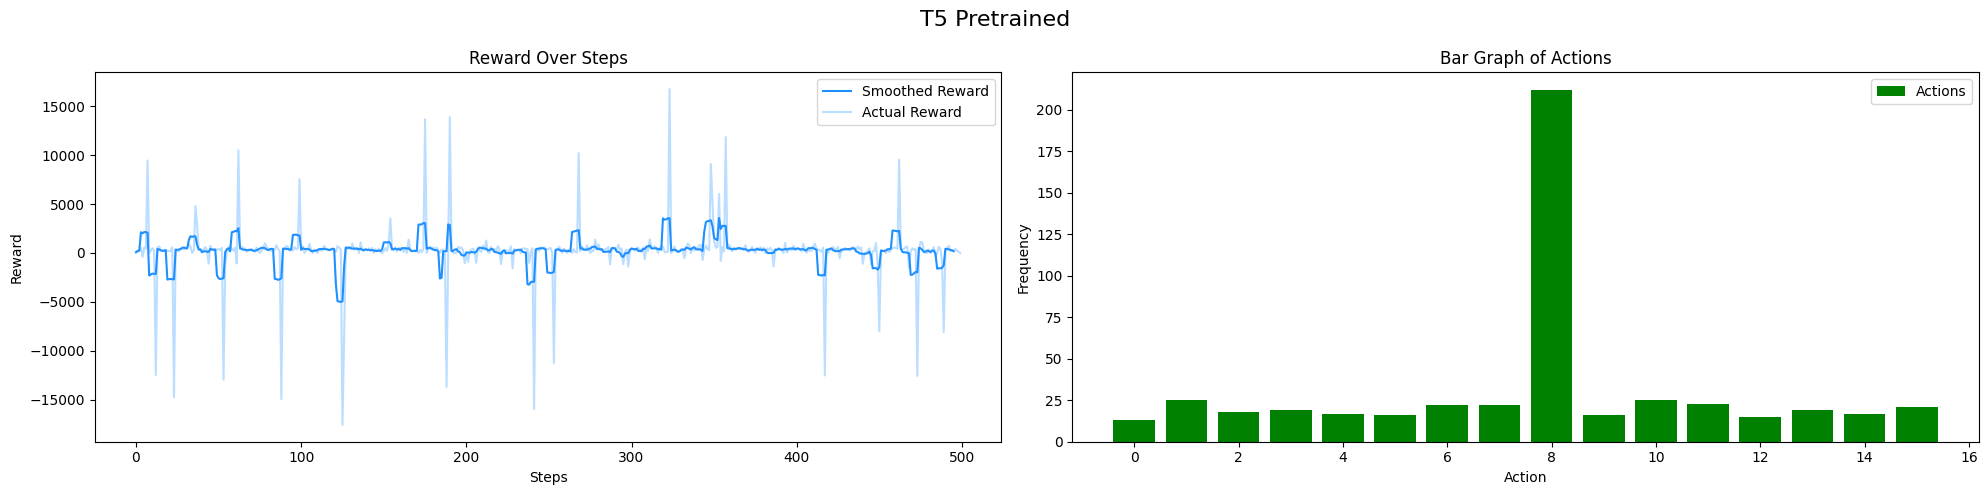

In [16]:
e_actions = [float(item[0]) for item in episode_actions]
e_rewards = [float(item[0]) for item in episode_rewards]


N = 5
smoothed_rewards = np.convolve(np.squeeze(episode_rewards), np.ones(N)/N, mode='valid')


fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Plotting reward
axs[0].plot(smoothed_rewards, color='dodgerblue')
axs[0].plot(episode_rewards, color='dodgerblue', alpha=0.3)
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('Reward')
axs[0].set_title('Reward Over Steps')
axs[0].legend(['Smoothed Reward', 'Actual Reward'])

# Plotting bar graph of actions
unique_actions, action_counts = np.unique(np.concatenate(episode_actions), return_counts=True)
plt.bar(unique_actions, action_counts, color='green')
axs[1].set_xlabel('Action')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Bar Graph of Actions')
axs[1].legend(['Actions'])


fig.suptitle('T5 Pretrained', fontsize=16)
plt.tight_layout()
plt.show()

In [17]:
print(episode_rewards)
print(episode_actions)

[array([0.], dtype=float32), array([154.54553], dtype=float32), array([154.54553], dtype=float32), array([531.62714], dtype=float32), array([-386.4863], dtype=float32), array([570.7222], dtype=float32), array([437.5263], dtype=float32), array([9455.277], dtype=float32), array([0.], dtype=float32), array([245.11717], dtype=float32), array([486.81937], dtype=float32), array([224.25319], dtype=float32), array([-12483.56], dtype=float32), array([570.672], dtype=float32), array([657.9319], dtype=float32), array([364.67783], dtype=float32), array([198.97392], dtype=float32), array([252.60075], dtype=float32), array([312.74014], dtype=float32), array([183.97334], dtype=float32), array([194.96965], dtype=float32), array([204.51944], dtype=float32), array([570.672], dtype=float32), array([-14735.027], dtype=float32), array([382.68335], dtype=float32), array([260.7374], dtype=float32), array([162.06326], dtype=float32), array([414.24652], dtype=float32), array([428.11978], dtype=float32), array(

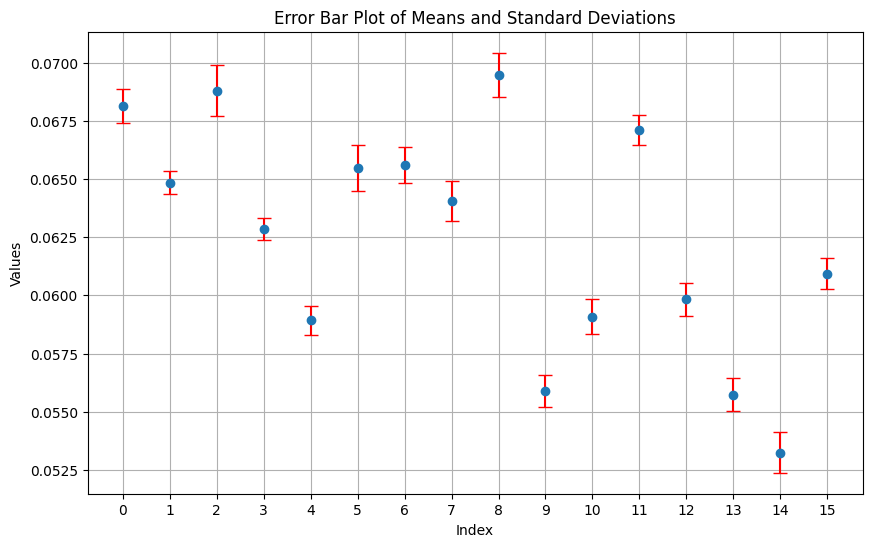

In [51]:
# Convert the list of tensors to a single tensor
data_tensor = torch.stack(proxy_prob)

# Calculate the mean and standard deviation for each index
means = torch.mean(data_tensor, dim=0)
std_devs = torch.std(data_tensor, dim=0)

means_np = means.cpu().detach().numpy()
std_devs_np = std_devs.cpu().detach().numpy()


# Data for plotting
indices = range(0, 16)

# Creating error bar plot
plt.figure(figsize=(10, 6))
plt.errorbar(indices, means_np[0], yerr=std_devs_np * 10, fmt='o', ecolor='red', capsize=5)
plt.title('Error Bar Plot of Means and Standard Deviations')
plt.xlabel('Index')
plt.ylabel('Values')
plt.xticks(indices)
plt.grid(True)
plt.show()



## Finetune

In [13]:
from transformers import Trainer, TrainingArguments

In [14]:
# Initialize the model
def model_init():
    return AutoModelForSeq2SeqLM.from_pretrained("Falconsai/text_summarization")

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("Falconsai/text_summarization")

def preprocess_data(examples):
    # Process articles and ensure they are strings
    articles = [str(action_list[8](example['article'])) if example['article'] is not None else "" for example in examples['info']]
    # Process summaries and ensure they are strings
    summaries = [str(summary['text']) if summary['text'] is not None else "" for summary in examples['summary']]

    model_inputs = tokenizer(articles, max_length=1024, padding="max_length", truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(summaries, max_length=128, padding="max_length", truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(preprocess_data, batched=True)


Map:   0%|          | 0/6312 [00:00<?, ? examples/s]

/home/local/ASURITE/bpathir1/miniconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:3860: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/8585 [00:00<?, ? examples/s]

In [16]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=3
)

# Initialize the Trainer
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_datasets["test"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer
)

# Train the model
trainer.train()


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,0.612900,10.857128
2,0.558400,11.091072
3,0.551800,11.229665


TrainOutput(global_step=9468, training_loss=0.634323637446221, metrics={'train_runtime': 1020.0299, 'train_samples_per_second': 18.564, 'train_steps_per_second': 9.282, 'total_flos': 5125664705347584.0, 'train_loss': 0.634323637446221, 'epoch': 3.0})

In [17]:
# # Assuming 'trainer' is your Trainer instance after training
# trainer.save_model("T5model/model")

# # Save the tokenizer associated with the model
# tokenizer.save_pretrained("T5model/tokenizer")

('T5model/tokenizer/tokenizer_config.json',
 'T5model/tokenizer/special_tokens_map.json',
 'T5model/tokenizer/tokenizer.json')

In [15]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("Finetune/T5model/tokenizer")
model = AutoModelForSeq2SeqLM.from_pretrained("Finetune/T5model/model")

In [19]:
def get_summary(text, max_length=130, min_length=40):
    # Encode the input text and add the special tokens for the model
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", truncation=True)

    # Generate summary with the model
    summary_ids = model.generate(inputs, max_length=max_length, min_length=min_length, length_penalty=2.0, num_beams=4, early_stopping=True)
    # Decode and return the summary
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Example usage
original_text = sentence*7
summary = get_summary(original_text)
print(summary)

Your example sentence here.Your example sentence here.Your example sentence here.Your example sentence here.Your example sentence here.Your example sentence here.Your example sentence here.Your example sentence here.Your example sentence here.Your example sentence here.


In [52]:
class T5Embedder:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained("Finetune/T5model/tokenizer")
        self.model = AutoModelForSeq2SeqLM.from_pretrained("Finetune/T5model/model").to(self.device)
        self.target_dim = 1024

    def get_embedding(self, text):
        # Tokenize with truncation
        task_prefix = "summarize: "  
        inputs = self.tokenizer(task_prefix + text, return_tensors='pt', max_length=1024, truncation=True).to(self.device)
        
        # Prepare decoder_input_ids
        decoder_input_ids = torch.full_like(inputs['input_ids'], self.model.config.decoder_start_token_id)
        with torch.no_grad():
            outputs = self.model(**inputs, decoder_input_ids=decoder_input_ids)
        embeddings = outputs.encoder_last_hidden_state
        embeddings = torch.mean(embeddings, dim=1)

        # Adjust the embedding to have the target dimension
        embedding_dim = embeddings.shape[1]
        if embedding_dim > self.target_dim:
            embeddings = embeddings[:, :self.target_dim]
        elif embedding_dim < self.target_dim:
            padding = torch.zeros((embeddings.shape[0], self.target_dim - embedding_dim)).to(self.device)
            embeddings = torch.cat([embeddings, padding], dim=1)

        return embeddings.cpu().numpy()


class NLPEnv(gym.Env):
    def __init__(self):
        super(NLPEnv, self).__init__()
        self.dataset = dataset
        self.current_word = None
        self.ground_truth = None
        self.embedder = T5Embedder()
        embedding_dim = 1024
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(embedding_dim,), dtype=np.float32)
        self.action_space = gym.spaces.Discrete(16)

        action_list = [
          drop_stop_words,
          remove_punctuation,
          to_lowercase,
          negate_sentence,
          delete_random_character,
          insert_random_character,
          change_letter_case,
          apply_misspellings,
          repeat_random_character,
          replace_with_adjacent_character,
          swap_random_character,
          delete_random_word,
          perturb_word_order,
          repeat_random_word,
          toggle_singular_plural,
          change_verb_tense
      ]


    def reset(self):
        random_index = random.randint(0, len(self.dataset['test']['info']) - 1)
        self.current_word = self.dataset['test']['info'][random_index]['article'][:3400]
        self.ground_truth = self.dataset['test']['summary'][random_index]['text']
        return self.embedder.get_embedding(self.current_word)

    def step(self, action):

        prediction = action_list[action](self.current_word)
        bleu_score = calculate_bleu_score(prediction, get_summary(prediction))

        reward = bleu_score*(len(prediction) - len(self.current_word))

        print(f'Action: {action_list_name[action]} Word length: {len(self.current_word)} Prediction length: {len(prediction)} Reward: {reward}')
        done = True

        return self.embedder.get_embedding(prediction), reward, done, {'current_word': self.current_word}


In [53]:
env = DummyVecEnv([lambda: NLPEnv()])
dqn_model_nlp_t5_re = DQN("MlpPolicy", env, verbose=1, exploration_final_eps=0.6, exploration_initial_eps=1.0)#DQN model

Using cuda device


/home/local/ASURITE/bpathir1/miniconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/home/local/ASURITE/bpathir1/miniconda3/lib/python3.11/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 8.21GB > 6.09GB
  warnings.warn(


In [54]:
# To Train
# dqn_model_nlp_t5_re.learn(1000)
#  dqn_model_nlp_t5_re.save('dqn_model_nlp_t5_refinetuned')

Action: replace_with_adjacent_character Word length: 2384 Prediction length: 2400 Reward: 119.79700522189324
Action: to_lowercase Word length: 2275 Prediction length: 2275 Reward: 0.0
Action: replace_with_adjacent_character Word length: 3400 Prediction length: 3447 Reward: 220.4276873749231
Action: replace_with_adjacent_character Word length: 3400 Prediction length: 3429 Reward: 227.61871343167306
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 3        |
|    total_timesteps  | 4        |
----------------------------------
Action: repeat_random_word Word length: 3400 Prediction length: 3419 Reward: 145.84555303821588
Action: remove_punctuation Word length: 3400 Prediction length: 3324 Reward: -934.6060376201393
Action: apply_misspellings Word length: 3400 Prediction length: 3400 Reward: 0.0
Action: rep

In [16]:
dqn_model_nlp_t5_re = DQN.load('RL models/dqn_model_nlp_t5_refinetuned')

In [20]:
episode_rewards_finetune = []
episode_actions_finetune = []
proxy_prob_finetune = []

for episode in range(500):
    print(f"Episode: {episode}")
    done = False
    obs = env.reset()
    q_values = dqn_model_nlp_t5_re.policy.q_net(torch.tensor(obs, dtype=torch.float32, device = dqn_model_nlp_t5_re.device))
    action_probabilities = torch.nn.functional.softmax(q_values, dim=1)
    proxy_prob_finetune.append(action_probabilities)
    while not done:
        action, _ = dqn_model_nlp_t5_re.predict(obs)
        obs, reward, done, info = env.step(action)
        print(f'Actions : {action}, Reward: {reward}')
        episode_rewards_finetune.append(reward)
        episode_actions_finetune.append(action)

Episode: 0


Action: remove_punctuation Word length: 3400 Prediction length: 3312 Reward: -586.9434618072781
Actions : [1], Reward: [-586.9435]
Episode: 1
Action: change_letter_case Word length: 3400 Prediction length: 3454 Reward: 454.9291432703412
Actions : [6], Reward: [454.92914]
Episode: 2
Action: drop_stop_words Word length: 2943 Prediction length: 2077 Reward: -10939.737887437648
Actions : [0], Reward: [-10939.738]
Episode: 3
Action: repeat_random_word Word length: 2583 Prediction length: 2610 Reward: 157.5911841756401
Actions : [13], Reward: [157.59119]
Episode: 4
Action: perturb_word_order Word length: 3054 Prediction length: 3120 Reward: 866.4887496512627
Actions : [12], Reward: [866.4888]
Episode: 5
Action: remove_punctuation Word length: 3400 Prediction length: 3293 Reward: -1435.7839884345276
Actions : [1], Reward: [-1435.7839]
Episode: 6
Action: remove_punctuation Word length: 3054 Prediction length: 2968 Reward: -763.5564700397921
Actions : [1], Reward: [-763.55646]
Episode: 7
Action

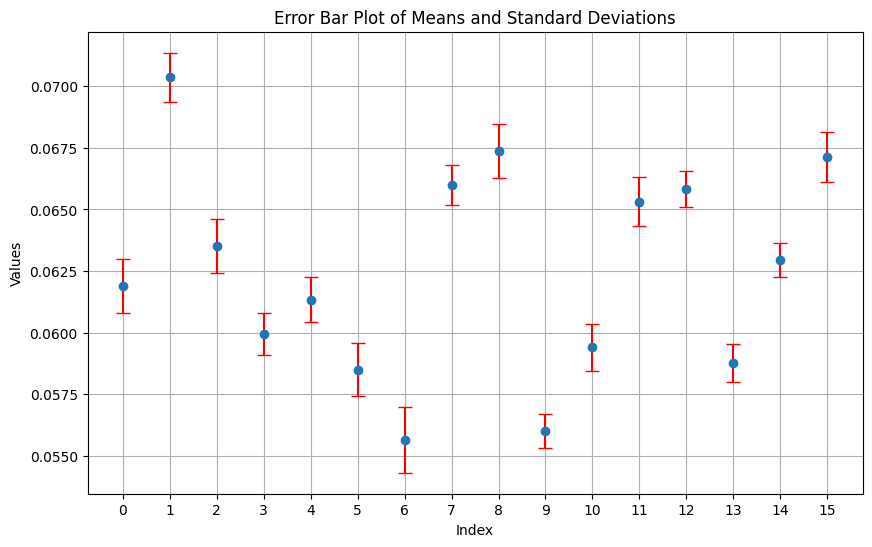

In [56]:
# Convert the list of tensors to a single tensor
data_tensor = torch.stack(proxy_prob_finetune)

# Calculate the mean and standard deviation for each index
means = torch.mean(data_tensor, dim=0)
std_devs = torch.std(data_tensor, dim=0)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

means_np = means.cpu().detach().numpy()
std_devs_np = std_devs.cpu().detach().numpy()


# Data for plotting
indices = range(0, 16)

# Creating error bar plot
plt.figure(figsize=(10, 6))
plt.errorbar(indices, means_np[0], yerr=std_devs_np * 10, fmt='o', ecolor='red', capsize=5)
plt.title('Error Bar Plot of Means and Standard Deviations')
plt.xlabel('Index')
plt.ylabel('Values')
plt.xticks(indices)
plt.grid(True)
plt.show()



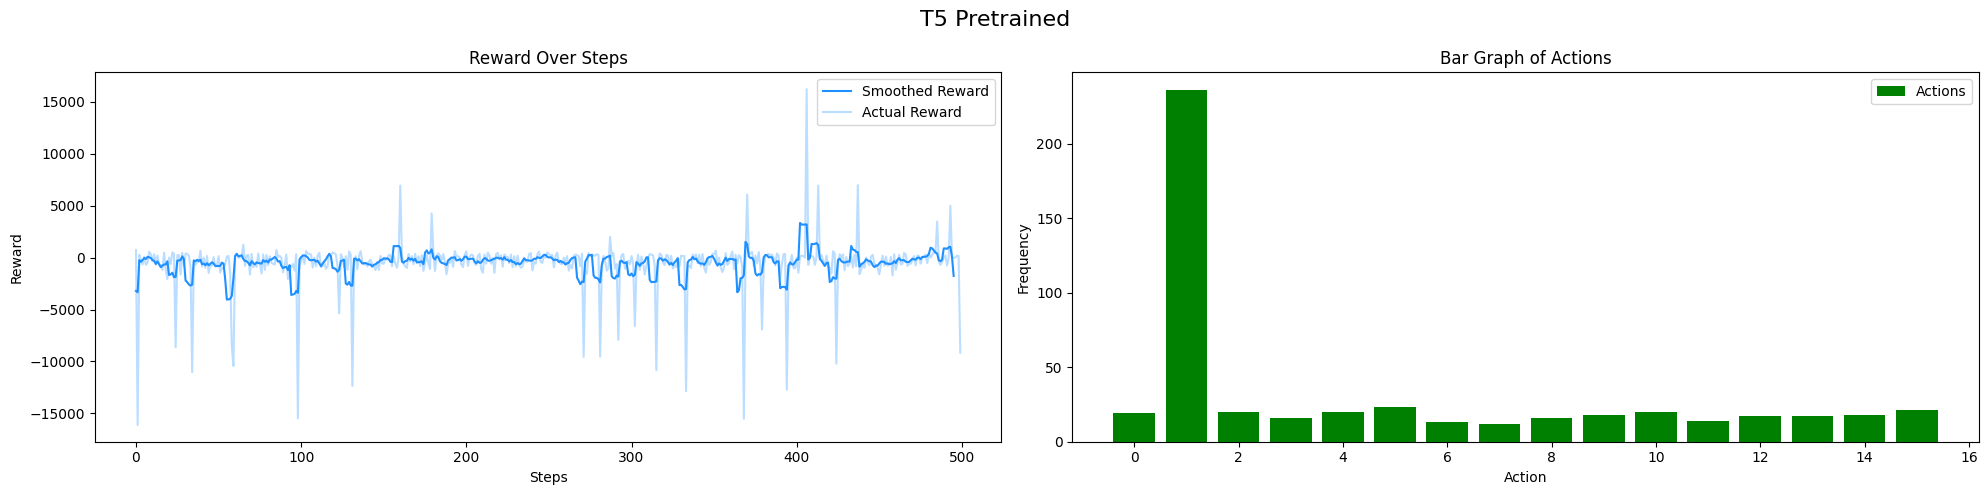

In [58]:
e_actions = [float(item[0]) for item in episode_actions_finetune]
e_rewards = [float(item[0]) for item in episode_rewards_finetune]


N = 5
smoothed_rewards = np.convolve(np.squeeze(episode_rewards_finetune), np.ones(N)/N, mode='valid')


fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Plotting reward
axs[0].plot(smoothed_rewards, color='dodgerblue')
axs[0].plot(episode_rewards_finetune, color='dodgerblue', alpha=0.3)
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('Reward')
axs[0].set_title('Reward Over Steps')
axs[0].legend(['Smoothed Reward', 'Actual Reward'])

# Plotting bar graph of actions
unique_actions, action_counts = np.unique(np.concatenate(episode_actions_finetune), return_counts=True)
plt.bar(unique_actions, action_counts, color='green')
axs[1].set_xlabel('Action')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Bar Graph of Actions')
axs[1].legend(['Actions'])


fig.suptitle('T5 Pretrained', fontsize=16)
plt.tight_layout()
plt.show()

In [61]:
print(episode_rewards_finetune)
sum(episode_rewards_finetune)

[array([729.8631], dtype=float32), array([-16118.559], dtype=float32), array([269.8991], dtype=float32), array([-262.0463], dtype=float32), array([-657.35254], dtype=float32), array([99.75445], dtype=float32), array([-696.21576], dtype=float32), array([-476.4799], dtype=float32), array([568.5869], dtype=float32), array([316.36496], dtype=float32), array([-375.4203], dtype=float32), array([329.7453], dtype=float32), array([-691.8473], dtype=float32), array([205.46907], dtype=float32), array([-678.583], dtype=float32), array([-700.222], dtype=float32), array([-1184.3955], dtype=float32), array([480.46133], dtype=float32), array([-1108.902], dtype=float32), array([-2062.0728], dtype=float32), array([0.], dtype=float32), array([-611.9825], dtype=float32), array([500.74252], dtype=float32), array([388.55713], dtype=float32), array([-8639.019], dtype=float32), array([238.02112], dtype=float32), array([243.50447], dtype=float32), array([-1633.5667], dtype=float32), array([463.81265], dtype=fl

array([-276394.44], dtype=float32)

: 

## Finetune 2

In [14]:
from transformers import Trainer, TrainingArguments

def model_init():
    return AutoModelForSeq2SeqLM.from_pretrained("Finetune/T5model2/model")

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("Finetune/T5model2/tokenizer")

def preprocess_data(examples):
    # Process articles and ensure they are strings
    articles = [str(action_list[1]((example['article']))) if example['article'] is not None else "" for example in examples['info']]
    # Process summaries and ensure they are strings
    summaries = [str(summary['text']) if summary['text'] is not None else "" for summary in examples['summary']]

    model_inputs = tokenizer(articles, max_length=1024, padding="max_length", truncation=True)

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(summaries, max_length=128, padding="max_length", truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(preprocess_data, batched=True)


Map:   0%|          | 0/6312 [00:00<?, ? examples/s]/home/local/ASURITE/bpathir1/miniconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:3860: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 8585/8585 [00:01<00:00, 6257.98 examples/s]


In [15]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=3
)

# Initialize the Trainer
trainer2 = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_datasets["test"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer
)

# Train the model
trainer2.train()


  0%|          | 0/9468 [00:00<?, ?it/s]You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
                                                  
  5%|▌         | 500/9468 [00:40<12:10, 12.27it/s] Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


{'loss': 1.7716, 'learning_rate': 1.8943810730882975e-05, 'epoch': 0.16}


                                                   
 11%|█         | 1000/9468 [01:22<11:36, 12.15it/s]

{'loss': 0.7591, 'learning_rate': 1.788762146176595e-05, 'epoch': 0.32}


                                                   
 16%|█▌        | 1500/9468 [02:03<10:52, 12.22it/s]

{'loss': 0.6873, 'learning_rate': 1.6831432192648923e-05, 'epoch': 0.48}


                                                   
 21%|██        | 2000/9468 [02:45<10:12, 12.20it/s]

{'loss': 0.6714, 'learning_rate': 1.5775242923531897e-05, 'epoch': 0.63}


                                                   
 26%|██▋       | 2500/9468 [03:26<09:34, 12.12it/s]

{'loss': 0.6448, 'learning_rate': 1.4719053654414873e-05, 'epoch': 0.79}


                                                   
 32%|███▏      | 3000/9468 [04:08<08:54, 12.11it/s]

{'loss': 0.6572, 'learning_rate': 1.3662864385297846e-05, 'epoch': 0.95}


 33%|███▎      | 3156/9468 [04:21<08:37, 12.20it/s]















































































































 33%|███▎      | 3156/9468 [04:34<08:37, 12.20it/s]










































































































































































































































































































































































































































































































































































































































































































































































                                       

{'eval_loss': 12.429890632629395, 'eval_runtime': 99.2413, 'eval_samples_per_second': 86.506, 'eval_steps_per_second': 43.258, 'epoch': 1.0}


                                                      
 37%|███▋      | 3500/9468 [06:29<08:08, 12.22it/s]

{'loss': 0.6438, 'learning_rate': 1.260667511618082e-05, 'epoch': 1.11}


                                                   
 42%|████▏     | 4000/9468 [07:11<07:30, 12.15it/s]

{'loss': 0.5947, 'learning_rate': 1.1550485847063794e-05, 'epoch': 1.27}


                                                   
 48%|████▊     | 4500/9468 [07:52<06:45, 12.26it/s]

{'loss': 0.6017, 'learning_rate': 1.049429657794677e-05, 'epoch': 1.43}


                                                   
 53%|█████▎    | 5000/9468 [08:34<06:04, 12.26it/s]

{'loss': 0.6236, 'learning_rate': 9.438107308829742e-06, 'epoch': 1.58}


                                                   
 58%|█████▊    | 5500/9468 [09:15<05:23, 12.27it/s]

{'loss': 0.5919, 'learning_rate': 8.381918039712717e-06, 'epoch': 1.74}


                                                   
 63%|██████▎   | 6000/9468 [09:56<04:44, 12.17it/s]

{'loss': 0.6013, 'learning_rate': 7.325728770595691e-06, 'epoch': 1.9}


 67%|██████▋   | 6311/9468 [10:23<04:21, 12.08it/s]




































































































 67%|██████▋   | 6312/9468 [10:34<04:21, 12.08it/s]





















































































































































































































































































































































































































































































































































































































































































































































































                                       

{'eval_loss': 12.651350021362305, 'eval_runtime': 99.0994, 'eval_samples_per_second': 86.63, 'eval_steps_per_second': 43.32, 'epoch': 2.0}


                                                      
 69%|██████▊   | 6500/9468 [12:17<04:01, 12.31it/s]

{'loss': 0.5899, 'learning_rate': 6.269539501478665e-06, 'epoch': 2.06}


                                                   
 74%|███████▍  | 7000/9468 [12:58<03:19, 12.36it/s]

{'loss': 0.5813, 'learning_rate': 5.213350232361639e-06, 'epoch': 2.22}


                                                   
 79%|███████▉  | 7500/9468 [13:39<02:39, 12.35it/s]

{'loss': 0.5911, 'learning_rate': 4.1571609632446135e-06, 'epoch': 2.38}


                                                   
 84%|████████▍ | 8000/9468 [14:20<01:59, 12.34it/s]

{'loss': 0.5698, 'learning_rate': 3.1009716941275882e-06, 'epoch': 2.53}


                                                   
 90%|████████▉ | 8500/9468 [15:01<01:18, 12.34it/s]

{'loss': 0.6019, 'learning_rate': 2.044782425010562e-06, 'epoch': 2.69}


                                                   
 95%|█████████▌| 9000/9468 [15:42<00:37, 12.36it/s]

{'loss': 0.5937, 'learning_rate': 9.885931558935361e-07, 'epoch': 2.85}


100%|█████████▉| 9467/9468 [16:21<00:00, 12.37it/s]





















































































































100%|██████████| 9468/9468 [16:34<00:00, 12.37it/s]




































































































































































































































































































































































































































































































































































































































































































































































                                       

{'eval_loss': 12.746064186096191, 'eval_runtime': 99.7048, 'eval_samples_per_second': 86.104, 'eval_steps_per_second': 43.057, 'epoch': 3.0}
{'train_runtime': 1080.9475, 'train_samples_per_second': 17.518, 'train_steps_per_second': 8.759, 'train_loss': 0.6824154871951491, 'epoch': 3.0}


TrainOutput(global_step=9468, training_loss=0.6824154871951491, metrics={'train_runtime': 1080.9475, 'train_samples_per_second': 17.518, 'train_steps_per_second': 8.759, 'train_loss': 0.6824154871951491, 'epoch': 3.0})

In [17]:
# # Assuming 'trainer' is your Trainer instance after training
# trainer2.save_model("Finetune/T5model2/model")

# # Save the tokenizer associated with the model
# tokenizer.save_pretrained("Finetune/T5model2/tokenizer")

('T5model2/tokenizer/tokenizer_config.json',
 'T5model2/tokenizer/special_tokens_map.json',
 'T5model2/tokenizer/tokenizer.json')

In [23]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("Finetune/T5model2/tokenizer")
model = AutoModelForSeq2SeqLM.from_pretrained("Finetune/T5model2/model")

## RL on fine tuned model twice

In [17]:
class T5Embedder:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained("Finetune/T5model/tokenizer")
        self.model = AutoModelForSeq2SeqLM.from_pretrained("Finetune/T5model/model").to(self.device)
        self.target_dim = 1024

    def get_embedding(self, text):
        # Tokenize with truncation
        task_prefix = "summarize: "  # or any other task-specific prefix
        inputs = self.tokenizer(task_prefix + text, return_tensors='pt', max_length=1024, truncation=True).to(self.device)
        
        # Prepare decoder_input_ids
        decoder_input_ids = torch.full_like(inputs['input_ids'], self.model.config.decoder_start_token_id)
        with torch.no_grad():
            outputs = self.model(**inputs, decoder_input_ids=decoder_input_ids)
        embeddings = outputs.encoder_last_hidden_state
        embeddings = torch.mean(embeddings, dim=1)

        # Adjust the embedding to have the target dimension
        embedding_dim = embeddings.shape[1]
        if embedding_dim > self.target_dim:
            embeddings = embeddings[:, :self.target_dim]
        elif embedding_dim < self.target_dim:
            padding = torch.zeros((embeddings.shape[0], self.target_dim - embedding_dim)).to(self.device)
            embeddings = torch.cat([embeddings, padding], dim=1)

        return embeddings.cpu().numpy()


class NLPEnv(gym.Env):
    def __init__(self):
        super(NLPEnv, self).__init__()
        self.dataset = dataset
        self.current_word = None
        self.ground_truth = None
        self.embedder = T5Embedder()
        embedding_dim = 1024
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(embedding_dim,), dtype=np.float32)
        self.action_space = gym.spaces.Discrete(16)

        action_list = [
          drop_stop_words,
          remove_punctuation,
          to_lowercase,
          negate_sentence,
          delete_random_character,
          insert_random_character,
          change_letter_case,
          apply_misspellings,
          repeat_random_character,
          replace_with_adjacent_character,
          swap_random_character,
          delete_random_word,
          perturb_word_order,
          repeat_random_word,
          toggle_singular_plural,
          change_verb_tense
      ]


    def reset(self):
        random_index = random.randint(0, len(self.dataset['test']['info']) - 1)
        self.current_word = self.dataset['test']['info'][random_index]['article'][:3400]
        self.ground_truth = self.dataset['test']['summary'][random_index]['text']
        return self.embedder.get_embedding(self.current_word)

    def step(self, action):

        prediction = action_list[action](self.current_word)
        bleu_score = calculate_bleu_score(prediction, get_summary(prediction))

        reward = bleu_score*(len(prediction) - len(self.current_word))

        print(f'Action: {action_list_name[action]} Word length: {len(self.current_word)} Prediction length: {len(prediction)} Reward: {reward}')
        done = True

        return self.embedder.get_embedding(prediction), reward, done, {'current_word': self.current_word}


In [22]:
env = DummyVecEnv([lambda: NLPEnv()])
dqn_model3_Fine2 = DQN("MlpPolicy", env, verbose=1, exploration_final_eps=0.6, exploration_initial_eps=1.0)#DQN model

Using cuda device


/home/local/ASURITE/bpathir1/miniconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [23]:
# dqn_model3_Fine2.learn(1000)
# dqn_model3_Fine2.save('dqn_model_nlp_t5_finetuned2')

Action: toggle_singular_plural Word length: 3400 Prediction length: 3441 Reward: 365.0673431713756
Action: insert_random_character Word length: 3241 Prediction length: 3281 Reward: 172.9073321076072
Action: repeat_random_word Word length: 3400 Prediction length: 3515 Reward: 903.9183702359408
Action: replace_with_adjacent_character Word length: 2638 Prediction length: 2652 Reward: 109.61790728121458
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 3        |
|    total_timesteps  | 4        |
----------------------------------
Action: apply_misspellings Word length: 3400 Prediction length: 3400 Reward: 0.0
Action: replace_with_adjacent_character Word length: 1843 Prediction length: 1858 Reward: 301.1113332119227
Action: remove_punctuation Word length: 2650 Prediction length: 2602 Reward: -583.44491344078

  8%|▊         | 986/12624 [28:51<5:40:40,  1.76s/it]


Action: change_letter_case Word length: 3400 Prediction length: 3429 Reward: 227.61871343167306
Action: repeat_random_character Word length: 3400 Prediction length: 3459 Reward: 388.18396298537715
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.776    |
| time/               |          |
|    episodes         | 56       |
|    fps              | 1        |
|    time_elapsed     | 55       |
|    total_timesteps  | 56       |
----------------------------------
Action: to_lowercase Word length: 2891 Prediction length: 2891 Reward: 0.0
Action: apply_misspellings Word length: 3400 Prediction length: 3400 Reward: 0.0
Action: repeat_random_word Word length: 1946 Prediction length: 2029 Reward: 674.9626007067125
Action: remove_punctuation Word length: 3400 Prediction length: 3296 Reward: -480.66497642819735
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.76     |
| time/               |          |


In [18]:
dqn_model3_Fine2 = DQN.load('RL models/dqn_model_nlp_t5_finetuned2')

In [25]:
episode_rewards_finetune2 = []
episode_actions_finetune2 = []
proxy_prob_finetune2 = []

for episode in range(500):
    print(f"Episode: {episode}")
    done = False
    obs = env.reset()
    q_values = dqn_model3_Fine2.policy.q_net(torch.tensor(obs, dtype=torch.float32, device = dqn_model3_Fine2.device))
    action_probabilities = torch.nn.functional.softmax(q_values, dim=1)
    proxy_prob_finetune2.append(action_probabilities)
    while not done:
        action, _ = dqn_model3_Fine2.predict(obs)
        obs, reward, done, info = env.step(action)
        print(f'Actions : {action}, Reward: {reward}')
        episode_rewards_finetune2.append(reward)
        episode_actions_finetune2.append(action)

Episode: 0
Action: negate_sentence Word length: 3400 Prediction length: 4560 Reward: 8235.296316681532
Actions : [3], Reward: [8235.296]
Episode: 1
Action: swap_random_character Word length: 2102 Prediction length: 2146 Reward: 317.1420799529865
Actions : [10], Reward: [317.1421]
Episode: 2
Action: insert_random_character Word length: 3400 Prediction length: 3440 Reward: 210.7375004507478
Actions : [5], Reward: [210.7375]
Episode: 3
Action: repeat_random_word Word length: 3400 Prediction length: 3451 Reward: 292.16324982388784
Actions : [13], Reward: [292.16324]
Episode: 4
Action: delete_random_word Word length: 2238 Prediction length: 2249 Reward: 154.84591657656284
Actions : [11], Reward: [154.84592]
Episode: 5
Action: repeat_random_word Word length: 3400 Prediction length: 3415 Reward: 181.34537832595336
Actions : [13], Reward: [181.34538]
Episode: 6
Action: insert_random_character Word length: 3400 Prediction length: 3424 Reward: 163.62695827505993
Actions : [5], Reward: [163.62695

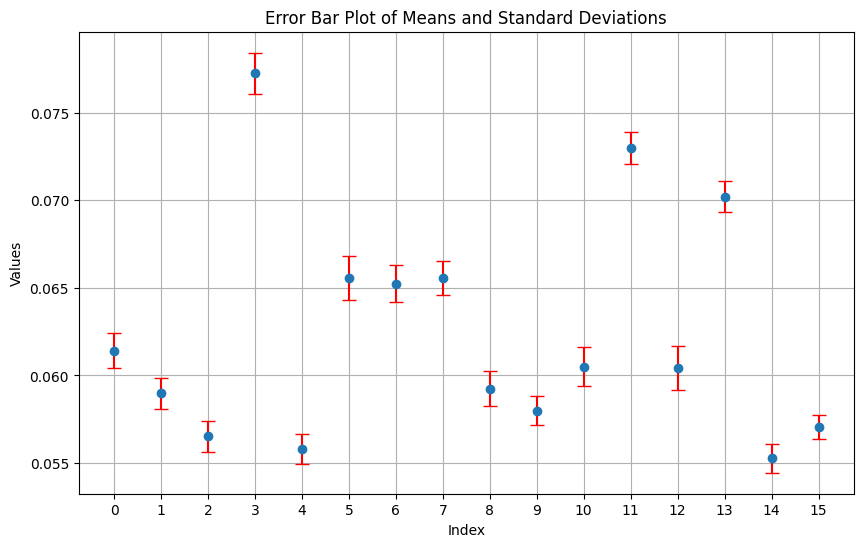

In [27]:
# Convert the list of tensors to a single tensor
data_tensor = torch.stack(proxy_prob_finetune2)

# Calculate the mean and standard deviation for each index
means = torch.mean(data_tensor, dim=0)
std_devs = torch.std(data_tensor, dim=0)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

means_np = means.cpu().detach().numpy()
std_devs_np = std_devs.cpu().detach().numpy()


# Data for plotting
indices = range(0, 16)

# Creating error bar plot
plt.figure(figsize=(10, 6))
plt.errorbar(indices, means_np[0], yerr=std_devs_np * 10, fmt='o', ecolor='red', capsize=5)
plt.title('Error Bar Plot of Means and Standard Deviations')
plt.xlabel('Index')
plt.ylabel('Values')
plt.xticks(indices)
plt.grid(True)
plt.show()



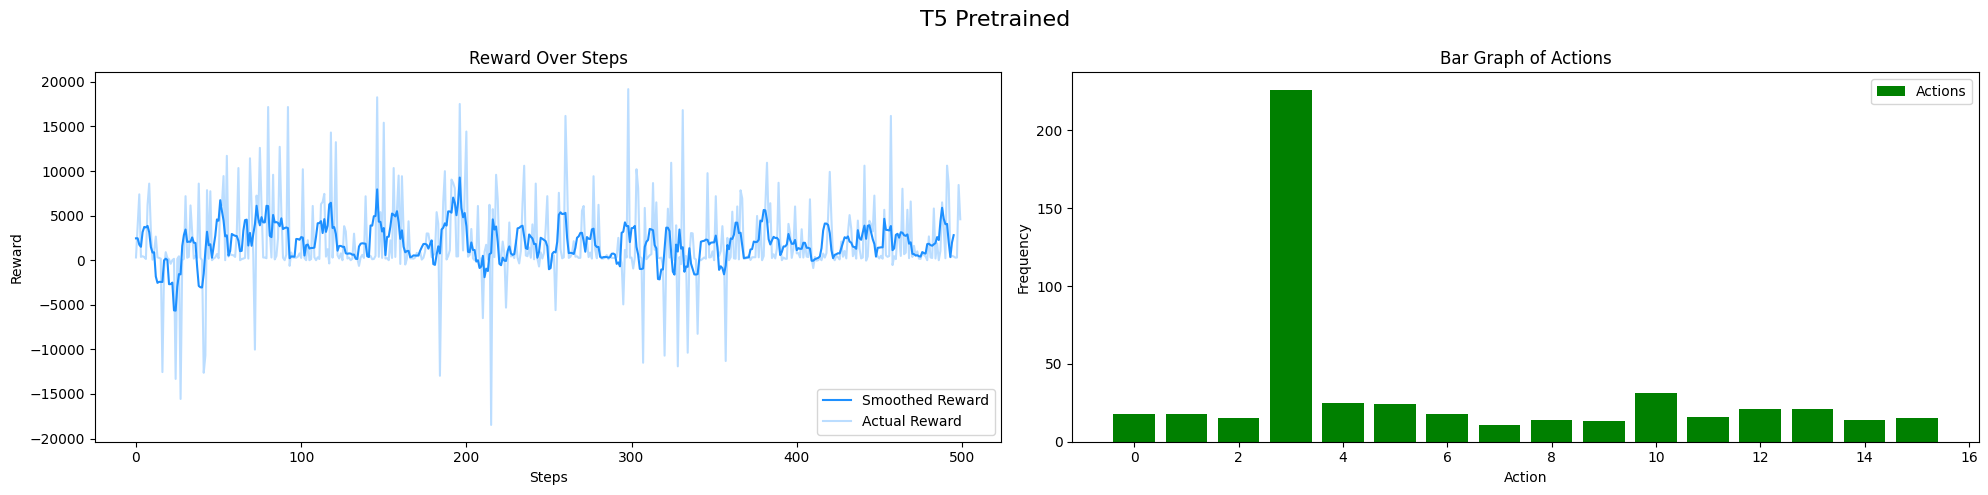

In [29]:
e_actions = [float(item[0]) for item in episode_actions_finetune2]
e_rewards = [float(item[0]) for item in episode_rewards_finetune2]


N = 5
smoothed_rewards = np.convolve(np.squeeze(episode_rewards_finetune2), np.ones(N)/N, mode='valid')


fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Plotting reward
axs[0].plot(smoothed_rewards, color='dodgerblue')
axs[0].plot(episode_rewards_finetune2, color='dodgerblue', alpha=0.3)
axs[0].set_xlabel('Steps')
axs[0].set_ylabel('Reward')
axs[0].set_title('Reward Over Steps')
axs[0].legend(['Smoothed Reward', 'Actual Reward'])

# Plotting bar graph of actions
unique_actions, action_counts = np.unique(np.concatenate(episode_actions_finetune2), return_counts=True)
plt.bar(unique_actions, action_counts, color='green')
axs[1].set_xlabel('Action')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Bar Graph of Actions')
axs[1].legend(['Actions'])


fig.suptitle('T5 Pretrained', fontsize=16)
plt.tight_layout()
plt.show()